# Wasserstein GAN in Pytorch

In [1]:
%matplotlib inline
import os
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.
/home/dwyatte/GitHub/fastai/courses/venv/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import torch_utils; importlib.reload(torch_utils)
from torch_utils import *

The good news is that in the last month the GAN training problem has been solved! [This paper](https://arxiv.org/abs/1701.07875) shows a minor change to the loss function and constraining the weights allows a GAN to reliably learn following a consistent loss schedule.

First, we, set up batch size, image size, and size of noise vector:

In [3]:
bs,sz,nz = 64,64,100

Pytorch has the handy [torch-vision](https://github.com/pytorch/vision) library which makes handling images fast and easy.

In [4]:
PATH = '../data/cifar10/'
data = datasets.CIFAR10(root=PATH, download=True,
   transform=transforms.Compose([
       transforms.Scale(sz),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
   ])
)

Files already downloaded and verified


In [5]:
# PATH = '../data/lsun/'

# data = datasets.LSUN(db_path='PATH', classes=['bedroom_train'],
#     transform=transforms.Compose([
#         transforms.Scale(sz),
#         transforms.CenterCrop(sz),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ]))

Even parallel processing is handling automatically by torch-vision.

In [6]:
dataloader = torch.utils.data.DataLoader(data, bs, True, num_workers=8)
n = len(dataloader); n

782

Our activation function will be `tanh`, so we need to do some processing to view the generated images.

In [7]:
def show(img, fs=(6,6)):
    plt.figure(figsize = fs)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')

## Create model

The CNN definitions are a little big for a notebook, so we import them.

In [8]:
import dcgan; importlib.reload(dcgan)
from dcgan import DCGAN_D, DCGAN_G

Pytorch uses `module.apply()` for picking an initializer.

In [9]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [10]:
netG = DCGAN_G(sz, nz, 3, 64, 1, 1).cuda()
netG.apply(weights_init);

In [11]:
netD = DCGAN_D(sz, 3, 64, 1, 1).cuda()
netD.apply(weights_init);

Just some shortcuts to create tensors and variables.

In [12]:
from torch import FloatTensor as FT
def Var(*params): return Variable(FT(*params).cuda())

In [13]:
def create_noise(b): 
    return Variable(FT(b, nz, 1, 1).cuda().normal_(0, 1))

In [14]:
# Input placeholder
input = Var(bs, 3, sz, nz)
# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)
# The numbers 0 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1

An optimizer needs to be told what variables to optimize. A module automatically keeps track of its variables.

In [15]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)

One forward step and one backward step for D

In [16]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [17]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [18]:
def train(niter, first=True):
    gen_iterations = 0
    for epoch in range(niter):
        data_iter = iter(dataloader)
        i = 0
        while i < n:
            make_trainable(netD, True)
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5)

            j = 0
            while j < d_iters and i < n:
                j += 1; i += 1
                for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                real = Variable(next(data_iter)[0].cuda())
                netD.zero_grad()
                errD_real = step_D(real, one)

                fake = netG(create_noise(real.size()[0]))
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, mone)
                errD = errD_real - errD_fake
                optimizerD.step()

            make_trainable(netD, False)
            netG.zero_grad()
            errG = step_D(netG(create_noise(bs)), one)
            optimizerG.step()
            gen_iterations += 1
            
        print('[%d/%d][%d/%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f' % (
            epoch, niter, gen_iterations, n,
            errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))

In [19]:
%time train(100, True)

[0/100][8/782] Loss_D: -1.547691 Loss_G: 0.753407 Loss_D_real: -0.809145 Loss_D_fake 0.738546
[1/100][16/782] Loss_D: -1.554238 Loss_G: 0.751400 Loss_D_real: -0.818496 Loss_D_fake 0.735743
[2/100][24/782] Loss_D: -1.563192 Loss_G: 0.757444 Loss_D_real: -0.820670 Loss_D_fake 0.742522
[3/100][162/782] Loss_D: -1.502628 Loss_G: 0.691902 Loss_D_real: -0.823667 Loss_D_fake 0.678961
[4/100][319/782] Loss_D: -1.503970 Loss_G: 0.692782 Loss_D_real: -0.824467 Loss_D_fake 0.679503
[5/100][476/782] Loss_D: -1.500470 Loss_G: 0.693541 Loss_D_real: -0.821010 Loss_D_fake 0.679460
[6/100][614/782] Loss_D: 0.061989 Loss_G: -0.651874 Loss_D_real: -0.632487 Loss_D_fake -0.694475
[7/100][771/782] Loss_D: -0.043701 Loss_G: -0.545274 Loss_D_real: -0.693208 Loss_D_fake -0.649507
[8/100][928/782] Loss_D: -1.419111 Loss_G: 0.682731 Loss_D_real: -0.731258 Loss_D_fake 0.687853
[9/100][1066/782] Loss_D: -1.281559 Loss_G: 0.607814 Loss_D_real: -0.635034 Loss_D_fake 0.646525
[10/100][1223/782] Loss_D: -0.876034 Los

[84/100][12450/782] Loss_D: -0.538280 Loss_G: 0.478580 Loss_D_real: -0.636918 Loss_D_fake -0.098638
[85/100][12588/782] Loss_D: -0.947479 Loss_G: 0.338065 Loss_D_real: -0.418755 Loss_D_fake 0.528724
[86/100][12745/782] Loss_D: -0.875532 Loss_G: 0.526753 Loss_D_real: -0.527124 Loss_D_fake 0.348408
[87/100][12902/782] Loss_D: -0.726680 Loss_G: 0.607570 Loss_D_real: -0.687199 Loss_D_fake 0.039481
[88/100][13040/782] Loss_D: -0.906291 Loss_G: 0.575229 Loss_D_real: -0.655059 Loss_D_fake 0.251232
[89/100][13197/782] Loss_D: -0.638806 Loss_G: 0.190105 Loss_D_real: -0.032603 Loss_D_fake 0.606203
[90/100][13354/782] Loss_D: -0.658644 Loss_G: 0.571387 Loss_D_real: -0.667891 Loss_D_fake -0.009248
[91/100][13501/782] Loss_D: -0.574025 Loss_G: 0.183765 Loss_D_real: 0.032815 Loss_D_fake 0.606840
[92/100][13658/782] Loss_D: -0.774370 Loss_G: 0.229617 Loss_D_real: -0.218645 Loss_D_fake 0.555725
[93/100][13815/782] Loss_D: -0.709783 Loss_G: 0.516208 Loss_D_real: -0.318009 Loss_D_fake 0.391773
[94/100][

## View

In [20]:
fake = netG(fixed_noise).data.cpu()

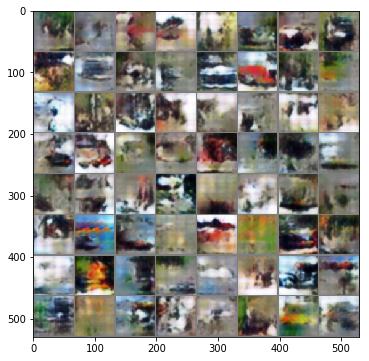

In [21]:
show(vutils.make_grid(fake))

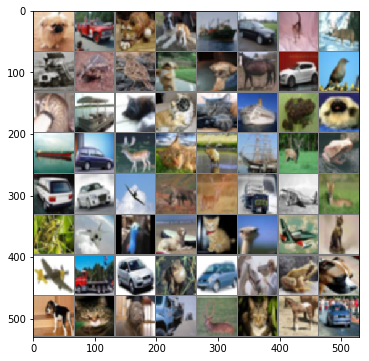

In [22]:
show(vutils.make_grid(iter(dataloader).next()[0]))

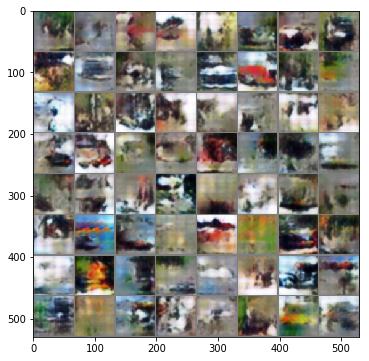

In [23]:
show(vutils.make_grid(fake))

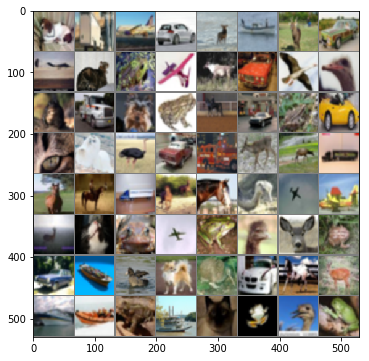

In [24]:
show(vutils.make_grid(iter(dataloader).next()[0]))